TV-Regularized Abel Inversion
=============================

This example demonstrates a TV-regularized Abel inversion by solving the
problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_1 \;,$$

where $A$ is the Abel projector (with an implementation based on a
projector from PyAbel <cite data-cite="pyabel-2022"/>), $\mathbf{y}$ is the measured
data, $C$ is a 2D finite difference operator, and $\mathbf{x}$ is the
desired image.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install 'scico[examples] @ git+https://github.com/lanl/scico'

import numpy as np

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.examples import create_circular_phantom
from scico.linop.abel import AbelTransform
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # image size
x_gt = create_circular_phantom((N, N), [0.4 * N, 0.2 * N, 0.1 * N], [1, 0, 0.5])

Set up the forward operator and create a test measurement.

In [3]:
A = AbelTransform(x_gt.shape)
y = A @ x_gt
np.random.seed(12345)
y = y + np.random.normal(size=y.shape).astype(np.float32)

Compute inverse Abel transform solution.

In [4]:
x_inv = A.inverse(y)

Set up the problem to be solved. Anisotropic TV, which gives slightly
better performance than isotropic TV for this problem, is used here.

In [5]:
f = loss.SquaredL2Loss(y=y, A=A)
λ = 2.35e1  # ℓ1 norm regularization parameter
g = λ * functional.L1Norm()  # Note the use of anisotropic TV
C = linop.FiniteDifference(input_shape=x_gt.shape)

Set up ADMM solver object.

In [6]:
ρ = 1.03e2  # ADMM penalty parameter
maxiter = 100  # number of ADMM iterations
cg_tol = 1e-4  # CG relative tolerance
cg_maxiter = 25  # maximum CG iterations per ADMM iteration

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=snp.clip(x_inv, 0.0, 1.0),
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
    itstat_options={"display": True, "period": 10},
)

Run the solver.

In [7]:
print(f"Solving on {device_info()}\n")
solver.solve()
hist = solver.itstat_object.history(transpose=True)
x_tv = snp.clip(solver.x, 0.0, 1.0)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.78e+00  5.897e+04  3.479e+01  7.425e+01     17  9.734e-05
  10  3.89e+00  5.973e+04  1.626e+00  6.635e-01      5  7.628e-05


  20  3.96e+00  6.132e+04  8.589e-01  6.671e-02      0  8.422e-05
  30  4.03e+00  6.182e+04  1.122e+00  2.967e-01      4  4.875e-05
  40  4.10e+00  6.209e+04  5.846e-01  1.733e-01      4  8.004e-05


  50  4.16e+00  6.224e+04  3.647e-01  2.823e-02      0  9.519e-05
  60  4.23e+00  6.247e+04  7.896e-01  2.614e-01      3  4.133e-05
  70  4.29e+00  6.259e+04  5.240e-01  3.870e-02      0  8.779e-05


  80  4.38e+00  6.262e+04  3.133e-01  2.373e-02      0  9.670e-05
  90  4.44e+00  6.266e+04  2.370e-01  5.154e-02      1  7.306e-05
  99  4.49e+00  6.268e+04  2.341e-01  1.609e-02      0  9.352e-05


Show results.

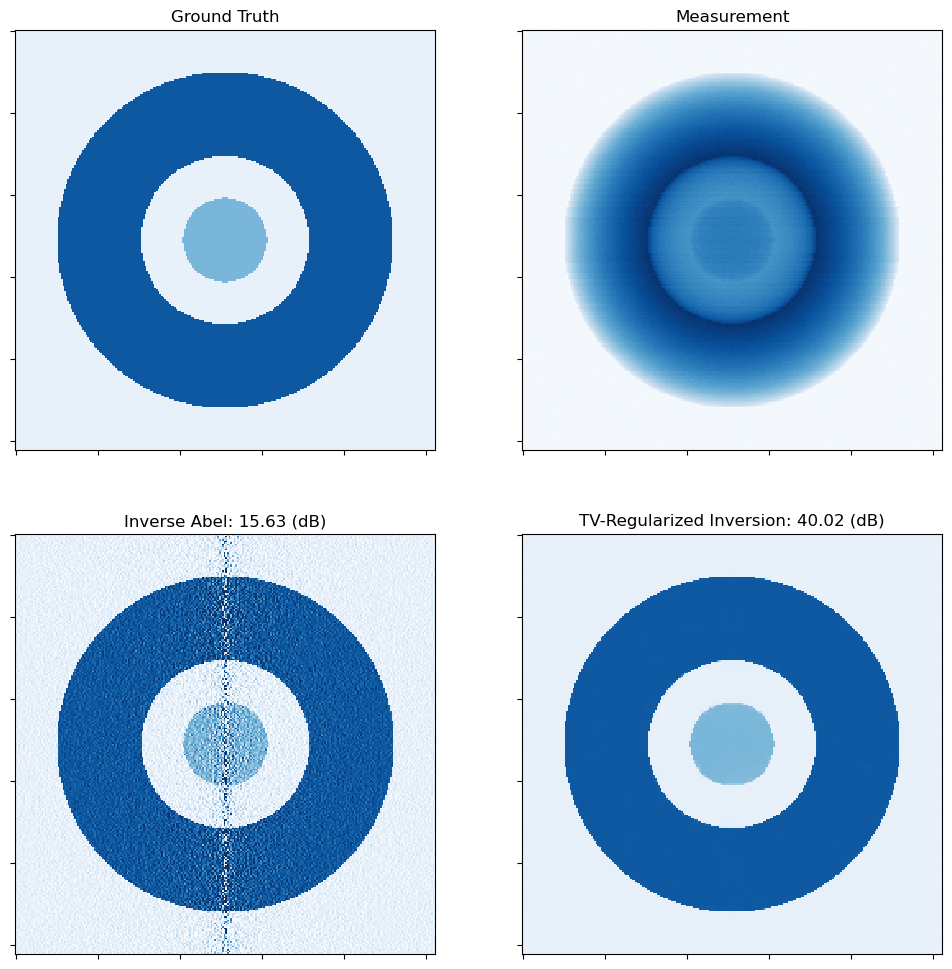

In [8]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1, vmax=1.2)
fig, ax = plot.subplots(nrows=2, ncols=2, figsize=(12, 12))
plot.imview(x_gt, title="Ground Truth", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 0], norm=norm)
plot.imview(y, title="Measurement", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 1])
plot.imview(
    x_inv,
    title="Inverse Abel: %.2f (dB)" % metric.psnr(x_gt, x_inv),
    cmap=plot.cm.Blues,
    fig=fig,
    ax=ax[1, 0],
    norm=norm,
)
plot.imview(
    x_tv,
    title="TV-Regularized Inversion: %.2f (dB)" % metric.psnr(x_gt, x_tv),
    cmap=plot.cm.Blues,
    fig=fig,
    ax=ax[1, 1],
    norm=norm,
)
fig.show()